# Comparison of WiSER with Heuristic Method (Standard Deviation of Residuals as Outcome) 

This notebook goes over the code needed to reproduce the results from the Figures 4 and 5, comparing WiSER with the heuristic method of using standard deviation of the residuals as an outcome in a linear regression.

The simulations were run in Julia version 1.4.0. `randn!()` function changed in v1.5.0, and will produce different random numbers for the simulation. 

#### Packages and Reproducibility

Julia allows for easy reproducibility, by including a `Manifest.toml` and `Project.toml` pair, the user can simply run `] activate .` and the correct environment with dependencies used will run.  

In [1]:
]activate .

 Activating environment at `~/WiSER_Reproduce/simulations/Project.toml`


Note: We use the KNITRO solver in our analysis, which requires a KNITRO license. If you wish to run the analysis without it, you can use another solver, but the results will be slightly different. To do this, comment out the code each time it says `solver = KNITRO...` and replace it with `solver = Ipopt.IpoptSolver(print_level=0, watchdog_shortened_iter_trigger=3, max_iter=100)`.

In [2]:
versioninfo()

Julia Version 1.5.0
Commit 96786e22cc (2020-08-01 23:44 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i9-9920X CPU @ 3.50GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)


**Note**: The simulation blocks take a long time to run on a standard PC. We have provided the output files, so please feel free to skip the simulation blocks.

The following code runs the simulation and saves results.

In [ ]:
using WiSER, DelimitedFiles, LinearAlgebra, Random, StatsBase, GLM, Statistics, KNITRO

# dimensions
@show Threads.nthreads()
p  = 5    # number of fixed effects, including intercept
q  = 2    # number of random effects, including intercept
l  = 5    # number of WS variance covariates, including intercept
q◺ = ◺(q)

# true parameter values
βtrue = [0.1; 6.5; 0.0; 1.0; 5]
τtrue = [0.0; 0.3; 0.0; 0.5; 0.25]
Σγ    = Matrix(Diagonal([2.0; 1.2]))
δγω   = [0.2; 0.1]
σω    = [1.0]
#τinvariant = [0.0; 0.5; -0.2]#estimates for time invariant 

Σγω   = [Σγ δγω; δγω' σω]
Lγω   = cholesky(Symmetric(Σγω), check = false).L
Lγ    = Lγω[1:q, 1:q]
lγω   = Lγω[q + 1, 1:q]
lω    = Lγω[q + 1, q + 1]

vechLγ = vech(Lγ)
# generate data
γω = Vector{Float64}(undef, q + 1)
z  = similar(γω) # hold vector of iid std normal

# trueparams = τinvariant[2:end] #hold true parameters

#simulation parameters
samplesizes = collect(1000:1000:6000)
ns = [10; 25; 50; 100; 1000]
nsims = 200

#storage for results
τpvals = Matrix{Float64}(undef, 4, nsims * length(ns) * length(samplesizes)) ###
naiveτpvals = Matrix{Float64}(undef, 4, nsims * length(ns) * length(samplesizes)) ###
solver = KNITRO.KnitroSolver(outlev=0)

xtx = zeros(p, p)
xty = zeros(p)
st = time()
currentind = 1
for t in 1:length(samplesizes)
    m = samplesizes[t]
    y_wssd = Vector{Float64}(undef, m)
    Winvariant = zeros(Float64, m, 5) ###
    for k in 1:length(ns)
        ni = ns[k] # number of observations per individual
        obsvec = Vector{WSVarLmmObs{Float64}}(undef, m)
        for j in 1:nsims
            fill!(xtx, 0)
            fill!(xty, 0)
            println("rep $j obs per person $ni samplesize $m")
            Random.seed!(j + 100000k + 1000t)
            for i in 1:m
                # covariates: gender, standardage, correlatedcovar
                gender = Distributions.rand(Bernoulli(0.5))
                standardage = Distributions.rand(Normal()) #0 effect size
                # correlatedcovar = standardage < 0 ? rand(Normal(-1.0, 1), ni) : rand(Normal(1.0, 1), ni) #0.5
                correlatedcovar = standardage < 0 ? rand(Normal(0.0, 0.5), ni) : rand(Normal(0.0, 2), ni) #0.5
                # X: intercept, gender, standardage, correlatedcovar, iid std normal
                X = Matrix{Float64}(undef, ni, p)
                X[:, 1] .= 1
                X[:, 2] .= gender
                X[:, 3] .= standardage
                X[:, 4] = correlatedcovar
                @views randn!(X[:, 5])
                # Z: intercept, std normal
                Z = Matrix{Float64}(undef, ni, q)
                Z[:, 1] .= 1.
                @views randn!(Z[:, 2:q])
                # W: intercept, gender, standardage, correlatedcovar, iid std normal
                W = Matrix{Float64}(undef, ni, l)
                W[:, 1] .= 1.0
                W[:, 2] .= gender
                W[:, 3] .= standardage
                W[:, 4] = correlatedcovar
                @views randn!(W[:, 5])
                # Winvariant: intercept, gender, standardage, mean(correlatedcovar), mean(iid std normal)
                Winvariant[i, 1] = 1.0
                Winvariant[i, 2] = gender
                Winvariant[i, 3] = standardage
                Winvariant[i, 4] = mean(correlatedcovar)
                Winvariant[i, 5] = mean(W[:, 5])
                # generate random effects: γω = Lγω * z
                mul!(γω, Lγω, Distributions.rand!(Normal(), z))
                # generate y
                μy = X * βtrue + Z * γω[1:q]
                @views vy = exp.(W * τtrue .+ dot(γω[1:q], lγω) .+ γω[end])
                y = rand(MvNormal(μy, Diagonal(vy)))
                # accumulate sufficient statistics for linear regression
                xtx .+= X'X
                xty .+= X'y
                # form a VarLmmObs instance
                obsvec[i] = WSVarLmmObs(y, X, Z, W)
            end
            # form VarLmmModel
            vlmm = WSVarLmmModel(obsvec);
            β̂lm = cholesky(Symmetric(xtx)) \ xty
            for i in 1:m
                obs = vlmm.data[i]
                # calculate std of residual vector of obs i
                y_wssd[i] = std(obs.y - transpose(obs.Xt) * β̂lm)
            end
            mod_sd = GLM.fit(LinearModel, Winvariant, y_wssd)
    # Error catching in the fit, if one solver fails try another solver. 
            try 
                WiSER.fit!(vlmm, solver, parallel = false)
                WiSER.confint(vlmm)
            catch
                println("rep $j ni obs = $ni , samplesize = $m had an error")
                try 
                    WiSER.fit!(vlmm, solver, init = init_mom!(vlmm), parallel = false)
                    WiSER.confint(vlmm)
                catch
                    println("rep $j ni obs = $ni , samplesize = $m had a second error")
                    try
                        WiSER.fit!(vlmm, parallel = false)
                        WiSER.confint(vlmm)
                    catch
    # if it fails to many times then record and throw it out
                        global currentind
                        println("rep $j ni obs = $ni , samplesize = $m had a third error")
                        τpvals[:, currentind] .= NaN
                        naiveτpvals[:, currentind] .= NaN
                        currentind += 1
                        continue
                    end
                end
            end
            global currentind
            naivepvals = GLM.coeftable(mod_sd).cols[4][2:end]
            naiveτpvals[:, currentind] = naivepvals
            τpvalues = WiSER.coeftable(vlmm).cols[4][p + 2 : p + l] ###
            τpvals[:, currentind] = τpvalues  
            currentind += 1
            vlmm = nothing 
            mod_sd = nothing
            GC.gc()
        end
    end
end
en = time()
            
ftail = "$(nsims)reps_correlated_comparesd.csv"
writedlm("result_files/naive_pvals" * ftail, naiveτpvals, ',')
writedlm("result_files/wiser_pvals" * ftail, τpvals, ',')

#### Results

The following code reproduces Figure 4.

In [5]:
# Read in data
using DelimitedFiles, LinearAlgebra, Random, StatsBase, Statistics, DataFrames
ENV["COLUMNS"]=800
naiveτpvals = readdlm("result_files/naive_pvals200reps_correlated_comparesd.csv", ',', header=false)
τpvals = readdlm("result_files/wiser_pvals200reps_correlated_comparesd.csv", ',', header=false)
findall(isnan.(naiveτpvals[1, :])) #27th sim fails 

1-element Array{Int64,1}:
 27

In [6]:
inds = [collect(1:26); collect(28:6000)];
noerror_wiser = τpvals[:, inds]
noerrror_naive = naiveτpvals[:, inds]

samplesizes = collect(1000:1000:6000)
ns = [10; 25; 50; 100; 1000]
nsims = 200
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

df2 = DataFrame(τ2wiser = τpvals[1, :], τ2naive = naiveτpvals[1, :],
        τ3wiser = τpvals[2, :], τ3naive= naiveτpvals[2, :],
        τ4wiser = τpvals[3, :], τ4naive = naiveτpvals[3, :],
        τ5wiser = τpvals[4, :], τ5naive= naiveτpvals[4, :],
    samplesize = sample_sizes, obssize = obs_sizes)

#some p-values are so small they are reported as 0, we set -log(10, p-value) to be 500 in this case. 

df2[!, :logτ2wiser] = ifelse.(df2[!, :τ2wiser] .== 0.0,  500, -log.(10, df2[!, :τ2wiser]))
df2[!, :logτ3wiser] = ifelse.(df2[!, :τ3wiser] .== 0.0,  500, -log.(10, df2[!, :τ3wiser]))
df2[!, :logτ4wiser] = ifelse.(df2[!, :τ4wiser] .== 0.0,  500, -log.(10, df2[!, :τ4wiser]))
df2[!, :logτ5wiser] = ifelse.(df2[!, :τ5wiser] .== 0.0,  rand(480:500, length(df2[!, :τ5wiser])),
    -log.(10, df2[!, :τ5wiser]))

df2[!, :logτ2naive] = ifelse.(df2[!, :τ2naive] .== 0.0,  500, -log.(10, df2[!, :τ2naive]))
df2[!, :logτ3naive] = ifelse.(df2[!, :τ3naive] .== 0.0,  500, -log.(10, df2[!, :τ3naive]))
df2[!, :logτ4naive] = ifelse.(df2[!, :τ4naive] .== 0.0,  500, -log.(10, df2[!, :τ4naive]))
df2[!, :logτ5naive] = ifelse.(df2[!, :τ5naive] .== 0.0,  rand(480:500, length(df2[!, :τ5naive])),
    -log.(10, df2[!, :τ5naive]))

df2 = df2[inds, :];

#### Figure 4

This creates figure 4.

┌ Info: Precompiling RCall [6f49c342-dc21-5d91-9882-a32aef131414]
└ @ Base loading.jl:1278


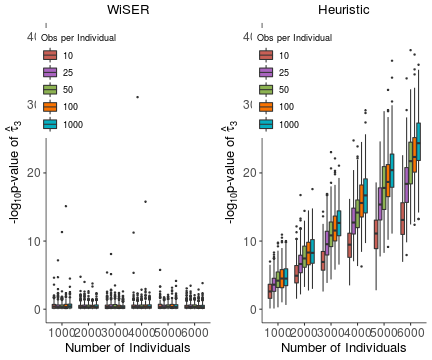

┌ Warning: RCall.jl: Warning: Removed 2 rows containing non-finite values (stat_boxplot).
└ @ RCall /home/cgerman/.julia/packages/RCall/Qzssx/src/io.jl:160


RObject{VecSxp}
TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


In [7]:
using RCall

df2R = deepcopy(df2)
rename!(df2R, [:t2wiser
        :t2naive
        :t3wiser
        :t3naive
        :t4wiser
        :t4naive
        :t5wiser
        :t5naive
        :samplesize
        :obssize
        :logt2wiser
        :logt3wiser
        :logt4wiser
        :logt5wiser
        :logt2naive
        :logt3naive
        :logt4naive
        :logt5naive])
@rput df2R
R"""
library(ggplot2)
library(gridExtra)
df2R$obssize <- factor(df2R$obssize, levels = c('10', '25', '50', '100', '1000'))
df2R$logt3wiser = unlist(df2R$logt3wiser)

tw3 <- ggplot(df2R, aes(x=samplesize, y=logt3wiser, fill=obssize)) + 
  geom_boxplot(outlier.size=0.5) +
  theme(legend.position=c(0.2,0.8), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=12),
        axis.text.y = element_text(angle=0, size=12), axis.title.x = element_text(size = 13), 
        axis.title.y = element_text(size = 13), legend.title = element_text(size = 9),
        #axis.ticks = element_blank(),
         panel.grid.major = element_blank(), legend.text=element_text(size=9),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0")) + 
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
ylim(0, 40) + 
  labs(x = "Number of Individuals", y = expression(paste("-",log[10],"p-value of ", hat(tau)[3])), fill = "Obs per Individual",
title = "WiSER")

tn3 <- ggplot(df2R, aes(x=samplesize, y=logt3naive, fill=obssize)) + 
  geom_boxplot(outlier.size=0.5) +
  theme(legend.position=c(0.2,0.8), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=12),
        axis.text.y = element_text(angle=0, size=12), axis.title.x = element_text(size = 13), 
        axis.title.y = element_text(size = 13), legend.title = element_text(size = 9),
        #axis.ticks = element_blank(),
         panel.grid.major = element_blank(), legend.text=element_text(size=9),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0")) + 
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
ylim(0, 40) +
  labs(x = "Number of Individuals", y = expression(paste("-",log[10],"p-value of ", hat(tau)[3])), fill = "Obs per Individual",
title = "Heuristic")

t3sd = grid.arrange(tw3, tn3, nrow=1, ncol=2)

"""

In [ ]:
#R"ggsave('result_files/compare_nullpvals_sd_200reps.png', t3sd, width = 10, height = 5, units = 'in', dpi = 450)"

WiSER reports similar power for all methods so we combine its power curve at different observations per person into one. 

In [8]:
t5wiserpower_all, t5wisermax_all, t5wisermin_all = combine(groupby(df2, :samplesize), 
    :τ5wiser => (x -> mean(x .< 0.05)) => :power,
    :τ5wiser => (x -> sem(x .< 0.05)) => :se) |> x -> (x.power, x.power + x.se, x.power - x.se);

[t5wiserpower_all t5wisermax_all t5wisermin_all]

6×3 Array{Float64,2}:
 0.981982  0.986193  0.977771
 0.995     0.997232  0.992768
 0.995     0.997232  0.992768
 0.999     1.0       0.998
 0.998     0.999414  0.996586
 0.996     0.997997  0.994003

In [9]:
t5naivepower, t5naivemax, t5naivemin = combine(groupby(df2, [:obssize, :samplesize]), :τ5naive => (x -> mean(x .< 0.05)) => :power,
    :τ5naive => (x -> sem(x .< 0.05)) => :se) |> x -> (x.power, x.power + x.se, x.power - x.se);

[t5naivepower t5naivemax t5naivemin]

30×3 Array{Float64,2}:
 0.286432  0.318561   0.254303
 0.175     0.201935   0.148065
 0.12      0.143036   0.0969641
 0.095     0.115785   0.0742145
 0.08      0.0992315  0.0607685
 0.61      0.644576   0.575424
 0.305     0.337637   0.272363
 0.215     0.244122   0.185878
 0.115     0.137615   0.0923851
 0.065     0.0824758  0.0475242
 0.715     0.747      0.683
 0.445     0.480229   0.409771
 0.32      0.353068   0.286932
 ⋮                    
 0.22      0.249365   0.190635
 0.055     0.0711611  0.0388389
 0.91      0.930287   0.889713
 0.675     0.708202   0.641798
 0.415     0.449928   0.380072
 0.255     0.285897   0.224103
 0.06      0.076835   0.043165
 0.97      0.982093   0.957907
 0.72      0.751829   0.688171
 0.51      0.545437   0.474563
 0.27      0.301471   0.238529
 0.07      0.0880869  0.0519131

In [10]:
t5powerdf = DataFrame(obssize = combine(groupby(df2, [:obssize, :samplesize]), :τ2wiser => x -> mean(x .< 0.05))[!, 1],
samplesize = combine(groupby(df2, [:obssize, :samplesize]), :τ2wiser => x -> mean(x .< 0.05))[!, 2],
    t5naivepower = t5naivepower, t5naivemax = t5naivemax, t5naivemin = t5naivemin)
df_w2 = DataFrame(t5wiserpower = t5wiserpower_all, t5wisermax = t5wisermax_all, t5wisermin = t5wisermin_all,
samplesize = string.(collect(1000:1000:6000)))
t5powerdf = leftjoin(t5powerdf, df_w2, on = :samplesize)

,obssize,samplesize,t5naivepower,t5naivemax,t5naivemin,t5wiserpower,t5wisermax,t5wisermin
,String,String,Float64,Float64,Float64,Float64?,Float64?,Float64?
1,10,1000,0.286432,0.318561,0.254303,0.981982,0.986193,0.977771
2,25,1000,0.175,0.201935,0.148065,0.981982,0.986193,0.977771
3,50,1000,0.12,0.143036,0.0969641,0.981982,0.986193,0.977771
4,100,1000,0.095,0.115785,0.0742145,0.981982,0.986193,0.977771
5,1000,1000,0.08,0.0992315,0.0607685,0.981982,0.986193,0.977771
6,10,2000,0.61,0.644576,0.575424,0.995,0.997232,0.992768
7,25,2000,0.305,0.337637,0.272363,0.995,0.997232,0.992768
8,50,2000,0.215,0.244122,0.185878,0.995,0.997232,0.992768
9,100,2000,0.115,0.137615,0.0923851,0.995,0.997232,0.992768


##### Figure 5

This recreates figure 5.

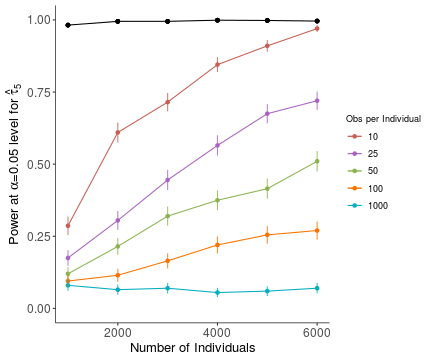

RObject{VecSxp}


In [11]:
using RCall

@rput t5powerdf
R"""
library(ggplot2)
library(gridExtra)
t5powerdf$obssize <- factor(t5powerdf$obssize, levels = c('10', '25', '50', '100', '1000'))
t5powerdf$samplesize <- as.numeric(as.character(t5powerdf$samplesize))#factor(df2R$obssize, levels = c('10', '25', '50', '100', '1000'))

#df2R$logt3wiser = unlist(df2R$logtwiser)

t5 <- ggplot(t5powerdf, aes(x=samplesize, y=t5naivepower, color = obssize)) + 
    geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=t5naivemin, ymax=t5naivemax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=12),
        axis.text.y = element_text(angle=0, size=12), axis.title.x = element_text(size = 13), 
        axis.title.y = element_text(size = 13), legend.title = element_text(size = 9),
        #axis.ticks = element_blank(),
         panel.grid.major = element_blank(), legend.text=element_text(size=9),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
  scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0")) + 
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
ylim(0, 1) +
  labs(x = "Number of Individuals", y = expression(paste("Power at ", alpha, "=0.05 level for ", hat(tau)[5])),
color = "Obs per Individual")#,
#title = "Power Comparison between naive (color) and WiSER (black)")
 
t5 = t5 +  geom_line(aes(x=samplesize, y=t5wiserpower), color="black") +
  geom_point(aes(x=samplesize, y=t5wiserpower), color="black")+
  geom_errorbar(aes(ymin=t5wisermin, ymax=t5wisermax), width=0.5, alpha = 0.8, position=position_dodge(0.005), color="black")
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x))
#ylim(0, 1) 
#  labs(x = "Number of Individuals", y = expression(paste("Power at ", alpha, "=0.05 level for ", hat(tau)[5])), fill = "Obs per Individual",
#title = "WiSER")

"""

In [ ]:
#R"ggsave('result_files/timevarpowercomp_2.png', t5, width = 6, height = 5, units = 'in', dpi = 450)"